In [1]:
import numpy as np
from scipy.io import savemat
from lib.kilo2plex import SimpleController, reorganize_by_prim_elec, renumber_unit_ids_from_global_to_local

kilo_sorted_dir = '../../kiloSorted_Nana32'

subsession_path = '/n100122/s1'

dir_path = kilo_sorted_dir + subsession_path
dat_path = dir_path + '/temp_wh.dat'   # signal file produced by kilosort to the working directory
sample_rate = 30000   # sampling rate used by the electrodes
n_channels_dat = 32   # number of electrodes
channel_rank = 0  # set to 0 for the primary channel, i.e. the electrode that contributed most in finding the unit.

channel_map = np.load(dir_path + '/channel_map.npy')
spike_clusters = np.load(dir_path + '/spike_clusters.npy')
spike_times = np.load(dir_path + '/spike_times.npy')
n_channels = channel_map.shape[1]
n_clusters = len(np.unique(spike_clusters))

max_spike_num_per_unit = len(spike_times)  # maximum number of spikes to retrieve from one unit

sc = SimpleController(dir_path, dat_path, sample_rate, n_channels_dat)
sc.n_spikes_waveforms = max_spike_num_per_unit

In [17]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# visualization example
# subplot_row_num = 9
subplot_row_num = 2
subplot_col_num = 3
subplot_num = subplot_row_num * subplot_col_num

def plot_waveforms(cluster_offset=0, n_spikes_to_visualize=sc.n_spikes_waveforms):
    figure(figsize=(subplot_col_num * 5, subplot_row_num * 3), dpi=80)
    for subplot_id in range(subplot_num):
        cluster_id = cluster_offset + subplot_id
        waveforms, _ = sc._get_waveforms(cluster_id)
        # waveforms.data: n_spikes, n_sample_time_points, n_channel_ranks                
        plt.subplot(subplot_row_num, subplot_col_num, subplot_id + 1)
        res = plt.plot(waveforms.data[:n_spikes_to_visualize,:,0].transpose())        
        plt.title('cluster ' + str(cluster_id) + ', main electrodes: ' + ','.join(waveforms.channel_labels[:5]))

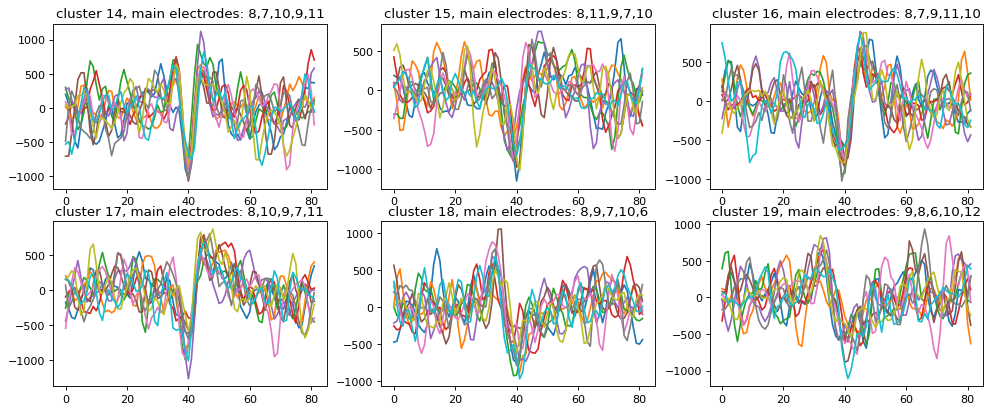

In [18]:
cluster_offset = np.random.randint(25)
plot_waveforms(cluster_offset=cluster_offset, n_spikes_to_visualize=10)

In [19]:
# plot_waveforms(cluster_offset=cluster_offset)

In [12]:
# get waveforms, spike_ids, and primary_electrodes for all clusters.
waveformsL = []
spike_idsL = []
primary_electrodeL = []   # map: cluster_id -> channel_id
for cluster_id in range(n_clusters):
    try:
        waveforms, spike_ids = sc._get_waveforms(cluster_id)
        waveformsL.append(waveforms.data[:,:,channel_rank])
        spike_idsL.append(spike_ids)
        primary_electrodeL.append(waveforms.channel_ids[0])
    except:
        print('cluster', cluster_id, 'missing.')

cluster 33 missing.
cluster 45 missing.
cluster 52 missing.
cluster 64 missing.
cluster 77 missing.
cluster 85 missing.
cluster 90 missing.
cluster 91 missing.
cluster 101 missing.
cluster 102 missing.


In [13]:
wvf_byc, times_byc, units_byc = reorganize_by_prim_elec(waveformsL, spike_times, spike_idsL, primary_electrodeL)
units_byc = renumber_unit_ids_from_global_to_local(units_byc)

In [14]:
# format and save a mat file.
wvf_t = np.array(wvf_byc, dtype=object)[np.newaxis].transpose()
times_t = np.array(times_byc, dtype=object)[np.newaxis].transpose()
units_t = np.array(units_byc, dtype=object)[np.newaxis].transpose()

k2o_mult = dict(times=times_t, wvf=wvf_t, units=units_t)
savemat('../k2o_mult.mat', k2o_mult)